IMPORT LIBRARY

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

LOAD DATASET

In [19]:
df = pd.read_csv('Coffe_sales.csv')
display(df.head())

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


DATA CLEANING 

In [20]:
duplikat = df.duplicated().sum()

print("Cek Missing Value:")
print(df.isnull().sum())
print(f"\nJumlah Data Duplikat: {duplikat}")

Cek Missing Value:
hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64

Jumlah Data Duplikat: 0


PREPROCESSING & FEATURE ENGINEERING

In [21]:
# A. Konversi tipe data Date dan Time
df['Date'] = pd.to_datetime(df['Date'])
# Mengambil jam dari kolom Time (format HH:MM:SS)
df['Time_Clean'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f', errors='coerce').dt.hour
# Jika error parsing, kita coba ambil dari kolom 'hour_of_day' kalau ada, atau fillna
if 'hour_of_day' in df.columns:
    df['hour_input'] = df['hour_of_day']
else:
    df['hour_input'] = df['Time_Clean']

# B. Memecah Tanggal menjadi Fitur Angka (Penting untuk Random Forest)
df['Month_Num'] = df['Date'].dt.month
df['Day_Num'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# C. Encoding Variabel Kategorial (Teks -> Angka)
le_coffee = LabelEncoder()
le_cash = LabelEncoder()

# Target (yang mau diprediksi)
df['coffee_name_encoded'] = le_coffee.fit_transform(df['coffee_name'])

# Fitur (Pendukung)
df['cash_type_encoded'] = le_cash.fit_transform(df['cash_type'])

EDA

In [22]:
bins = [0, 11, 17, 24]
labels = ['Pagi', 'Siang', 'Malam']
df['Waktu_Kategori'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels)

print("Data siap untuk EDA. Contoh data:")
display(df[['Date', 'coffee_name', 'money', 'Waktu_Kategori']].head())

# --- MULAI VISUALISASI ---
sns.set(style="whitegrid") # Mengatur gaya plot biar rapi

Data siap untuk EDA. Contoh data:


,Date,coffee_name,money,Waktu_Kategori
0,2024-03-01,Latte,38.7,Pagi
1,2024-03-01,Hot Chocolate,38.7,Siang
2,2024-03-01,Hot Chocolate,38.7,Siang
3,2024-03-01,Americano,28.9,Siang
4,2024-03-01,Latte,38.7,Siang


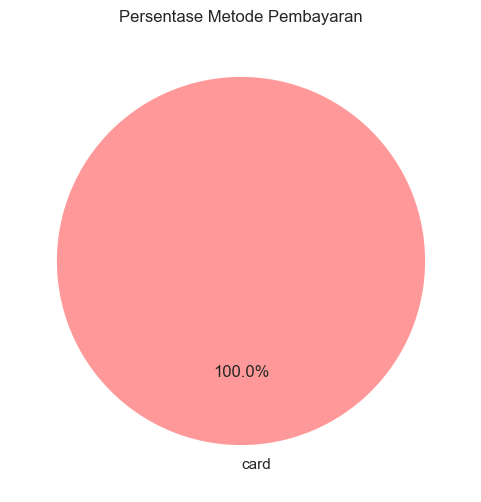

In [23]:
# Visualisasi 1: Distribusi Metode Pembayaran (Pie Chart)
# Tujuannya: Melihat kebiasaan bayar pelanggan (Cash vs Card)
plt.figure(figsize=(6, 6))
df['cash_type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Persentase Metode Pembayaran')
plt.ylabel('') # Menghilangkan label y biar bersih
plt.show()

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_16144\2952105558.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Waktu_Kategori', data=df, palette='pastel', order=['Pagi', 'Siang', 'Malam'])


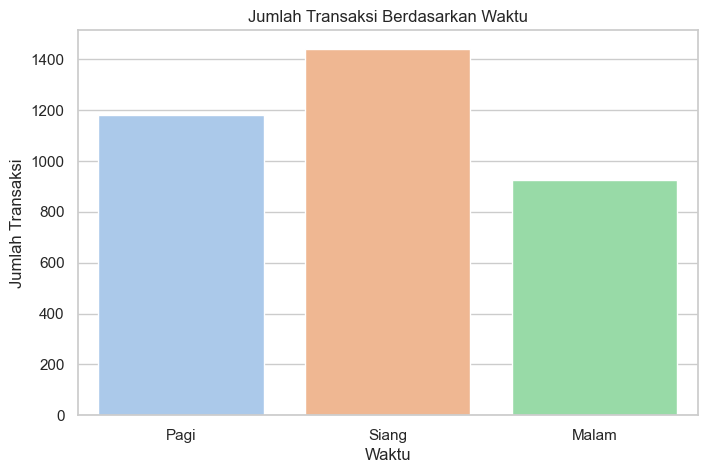

In [24]:
# Visualisasi 2: Kesibukan Toko Berdasarkan Waktu (Countplot)
# Tujuannya: Mengetahui kapan toko paling ramai (untuk strategi shift karyawan)
plt.figure(figsize=(8, 5))
sns.countplot(x='Waktu_Kategori', data=df, palette='pastel', order=['Pagi', 'Siang', 'Malam'])
plt.title('Jumlah Transaksi Berdasarkan Waktu')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Transaksi')
plt.show()

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_16144\4187847203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='money', y='coffee_name', data=df, palette='coolwarm')


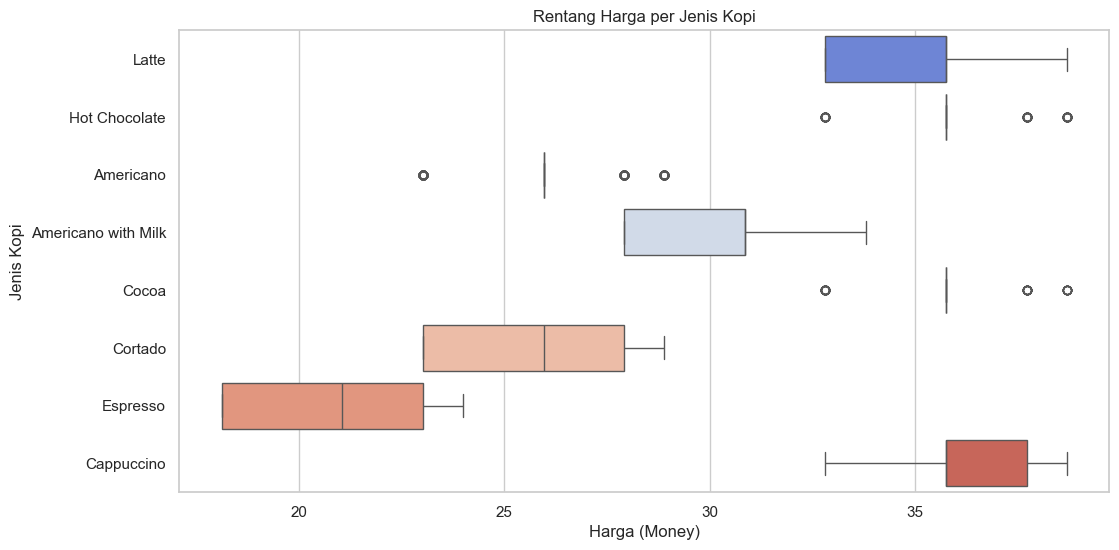

In [25]:
# Visualisasi 3: Sebaran Harga per Jenis Kopi (Boxplot)
# Tujuannya: Melihat rentang harga setiap kopi (Mahal vs Murah)
plt.figure(figsize=(12, 6))
sns.boxplot(x='money', y='coffee_name', data=df, palette='coolwarm')
plt.title('Rentang Harga per Jenis Kopi')
plt.xlabel('Harga (Money)')
plt.ylabel('Jenis Kopi')
plt.show()

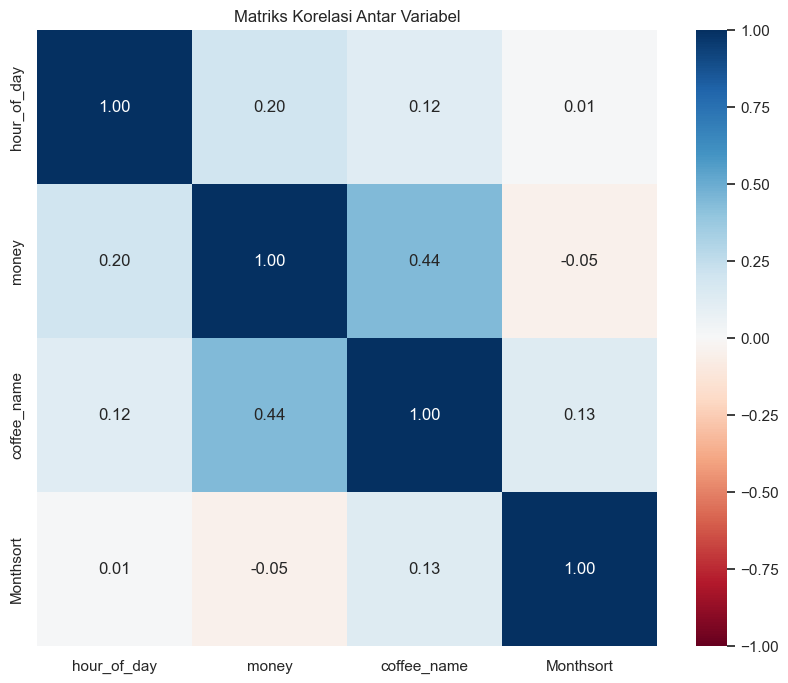

In [26]:
# Visualisasi 4: Matriks Korelasi (Heatmap)
# Tujuannya: Melihat hubungan antar variabel angka (Modul 3)
# Kita perlu encode sementara hanya untuk visualisasi ini
df_corr = df.copy()
le = LabelEncoder()
for col in ['coffee_name', 'cash_type', 'Month_name']:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.figure(figsize=(10, 8))
# Memilih kolom numerik untuk korelasi
numerical_cols = ['hour_of_day', 'money', 'coffee_name', 'Monthsort']
corr_matrix = df_corr[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriks Korelasi Antar Variabel')
plt.show()

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_16144\2203366376.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


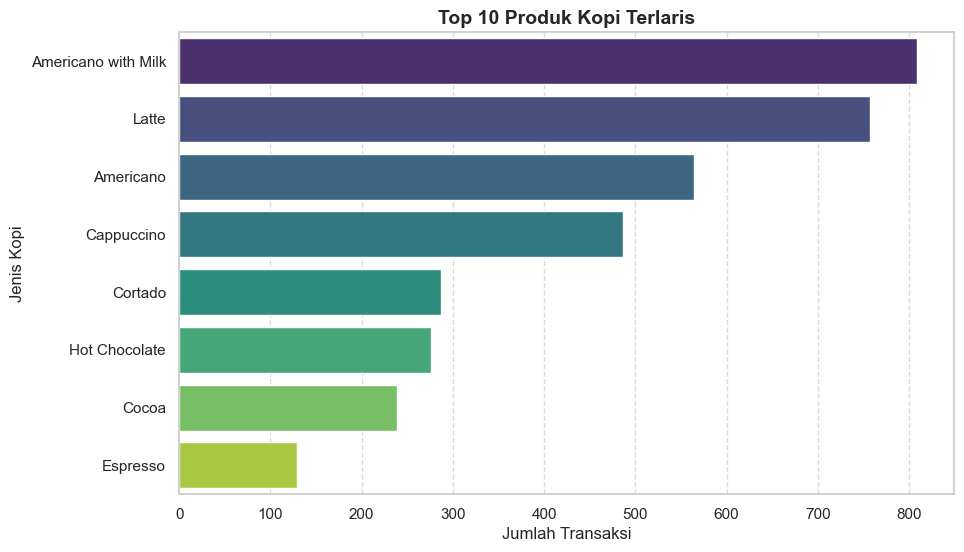

In [27]:
# Visualisasi 5: Top 10 Produk Terlaris
plt.figure(figsize=(10, 6))

# Menghitung jumlah transaksi per jenis kopi dan mengambil 10 terbanyak
# Pastikan menggunakan 'df' (data asli), bukan 'df_model' (data angka)
top_products = df['coffee_name'].value_counts().head(10)

# Membuat Bar Plot
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')

# Mempercantik Grafik
plt.title('Top 10 Produk Kopi Terlaris', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Transaksi', fontsize=12)
plt.ylabel('Jenis Kopi', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7) # Garis bantu tipis di belakang

plt.show()

LABEL ENCODING

In [28]:
df_model = df.copy()

le_coffee = LabelEncoder()
df_model['coffee_name'] = le_coffee.fit_transform(df_model['coffee_name'])
coffee_labels = dict(zip(range(len(le_coffee.classes_)), le_coffee.classes_))

le_features = LabelEncoder()
for col in ['cash_type', 'Month_name']:
    df_model[col] = le_features.fit_transform(df_model[col])

display(df_model.head())

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,Time_Clean,hour_input,Month_Num,Day_Num,Year,Is_Weekend,coffee_name_encoded,cash_type_encoded,Waktu_Kategori
0,10,0,38.7,7,Morning,Fri,7,5,3,2024-03-01,10:15:50.520000,10.0,10,3,1,2024,0,7,0,Pagi
1,12,0,38.7,6,Afternoon,Fri,7,5,3,2024-03-01,12:19:22.539000,12.0,12,3,1,2024,0,6,0,Siang
2,12,0,38.7,6,Afternoon,Fri,7,5,3,2024-03-01,12:20:18.089000,12.0,12,3,1,2024,0,6,0,Siang
3,13,0,28.9,0,Afternoon,Fri,7,5,3,2024-03-01,13:46:33.006000,13.0,13,3,1,2024,0,0,0,Siang
4,13,0,38.7,7,Afternoon,Fri,7,5,3,2024-03-01,13:48:14.626000,13.0,13,3,1,2024,0,7,0,Siang


DATA SPLITTING

In [29]:
x = df_model[['hour_of_day', 'money', 'cash_type', 'Monthsort']]
y = df_model['coffee_name']

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    random_state=42
)

print("Jumlah Data Training:", x_train.shape[0])
print("Jumlah Data Testing :", y_test.shape[0])

Jumlah Data Training: 2837
Jumlah Data Testing : 710


DATA SCALING

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

LATIH MODEL RANDOM FOREST

In [31]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

EVALUATION SCORE

In [32]:
# Prediksi
y_pred = rf_model.predict(X_test_scaled)
target_names = list(coffee_labels.values())

# Tampilkan Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

Accuracy Score: 0.6084507042253521

Classification Report:
                      precision    recall  f1-score   support

          Americano       0.79      0.70      0.74       128
Americano with Milk       0.99      0.98      0.98       163
         Cappuccino       0.34      0.36      0.35        90
              Cocoa       0.21      0.11      0.14        45
            Cortado       0.40      0.52      0.45        48
           Espresso       1.00      1.00      1.00        20
      Hot Chocolate       0.32      0.23      0.27        60
              Latte       0.46      0.56      0.50       156

           accuracy                           0.61       710
          macro avg       0.56      0.56      0.55       710
       weighted avg       0.61      0.61      0.60       710



VISUALISASI CONFUSION MATRIX

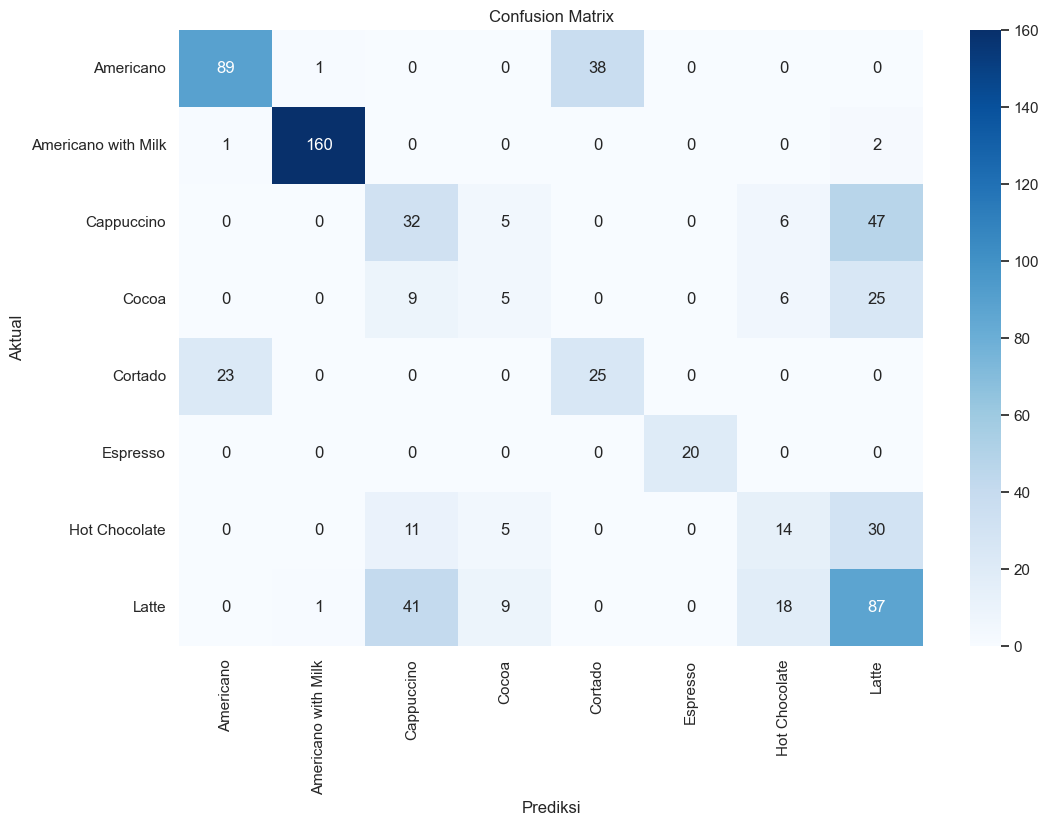

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

FEATUREIMPORTANCE

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_16144\1422038611.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Fitur', data=feature_df, palette='viridis')


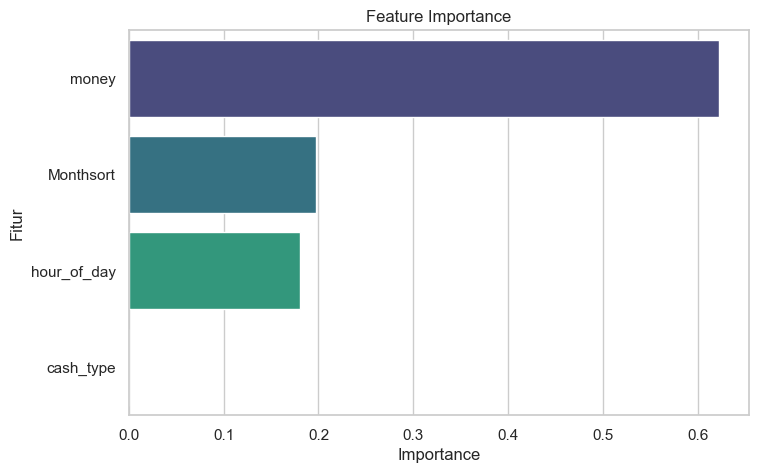

In [34]:
feature_df = pd.DataFrame({
    'Fitur': x.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Fitur', data=feature_df, palette='viridis')
plt.title('Feature Importance')
plt.show()